In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os
import sys

module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path :
    sys.path.append(module_path)

    
import _ressources.chain as chain
import _ressources.tools as tools
import _ressources.lumenclass as lc
import _ressources.configreader as configreader

#main_dir = '/Users/mathieuleverge/git/chain_lumen/_data/hydrosmotic_hydraulic/versus/N1000_hydraulic/'
main_dir = '/Users/mathieuleverge/git/chain_lumen/_data/'
subdir = 'patterning'
mu = (np.sin(np.pi/3.))**2 / (2*np.pi/3. - np.sin(2*np.pi/3.))

In [2]:
def event_counter(filename) :
    events = open(filename, 'r').read()
    Nmerge = events.count('merge')
    Ndis = events.count('disappears')
    return Ndis, Nmerge

def print_outcomes(events, tablename='') :
    if len(tablename) > 0 :
        s = '='*5 + ' ' + tablename + ' ' + '='*5
        print('='*len(s))
        print(s)
    else :
        s = '='*30
        print(s)
    print('Coarsening events  : ', events[0])
    print('Coalescence events : ', events[1])
    print('-'*len(s))
    print('Total              : ', events[0]+events[1])
    print('='*len(s))
    print('')

# Hydraulic

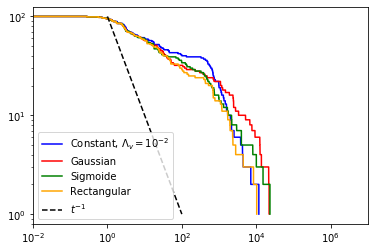

In [3]:
subsubdir = 'hydraulic'
Nt_constant = np.loadtxt(os.path.join(main_dir, subdir, subsubdir, 'run0000', 'sim_nlum.dat'))
Nt_gauss = np.loadtxt(os.path.join(main_dir, subdir, subsubdir, 'run0001', 'sim_nlum.dat'))
Nt_sig = np.loadtxt(os.path.join(main_dir, subdir, subsubdir, 'run0002', 'sim_nlum.dat'))
Nt_rec = np.loadtxt(os.path.join(main_dir, subdir, subsubdir, 'run0003', 'sim_nlum.dat'))

plt.xscale('log')
plt.yscale('log')
plt.plot(Nt_constant[:, 0], Nt_constant[:, 1], color = 'b', label = r'Constant, $\Lambda_v = 10^{-2}$')
plt.plot(Nt_gauss[:, 0], Nt_gauss[:, 1], color = 'r', label = r'Gaussian')
plt.plot(Nt_sig[:, 0], Nt_sig[:, 1], color = 'g', label = r'Sigmoide')
plt.plot(Nt_rec[:, 0], Nt_rec[:, 1], color = 'orange', label = r'Rectangular')

tp = np.logspace(0, 2, 101)
kp, ap = 100., -1.
plt.plot(tp, kp*tp**ap, label = r'$t^{-1}$', color='k', linestyle = '--')

plt.xlim(1e-2, 1e7)

plt.legend()
plt.show()


# Hydroosmotic

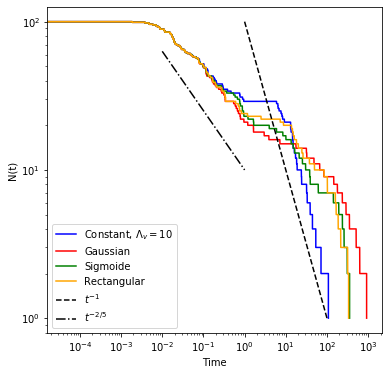

In [4]:
subsubdir = 'hydroosmotic'
Nt_constant = np.loadtxt(os.path.join(main_dir, subdir, subsubdir, 'run0000', 'sim_nlum.dat'))
Nt_gauss = np.loadtxt(os.path.join(main_dir, subdir, subsubdir, 'run0001', 'sim_nlum.dat'))
Nt_sig = np.loadtxt(os.path.join(main_dir, subdir, subsubdir, 'run0002', 'sim_nlum.dat'))
Nt_rec = np.loadtxt(os.path.join(main_dir, subdir, subsubdir, 'run0003', 'sim_nlum.dat'))

plt.figure(figsize=(6, 6))
plt.xscale('log')
plt.yscale('log')
plt.plot(Nt_constant[:, 0], Nt_constant[:, 1], color = 'b', label = r'Constant, $\Lambda_v = 10$')
plt.plot(Nt_gauss[:, 0], Nt_gauss[:, 1], color = 'r', label = r'Gaussian')
plt.plot(Nt_sig[:, 0], Nt_sig[:, 1], color = 'g', label = r'Sigmoide')
plt.plot(Nt_rec[:, 0], Nt_rec[:, 1], color = 'orange', label = r'Rectangular')

tp = np.logspace(0, 2, 101)
kp, ap = 100., -1.
plt.plot(tp, kp*tp**ap, label = r'$t^{-1}$', color='k', linestyle = '--')

tc = np.logspace(-2, 0, 101)
kc, ac = 10., -2./5.
plt.plot(tc, kc*tc**ac, label = r'$t^{-2/5}$', color='k', linestyle = '-.')

#plt.xlim(1e-2, 1e7)
plt.xlabel('Time')
plt.ylabel('N(t)')
plt.legend()
plt.show()



In [5]:
constant_events = event_counter(os.path.join(main_dir, subdir, subsubdir, 'run0000', 'events.log'))
gaussian_events = event_counter(os.path.join(main_dir, subdir, subsubdir, 'run0001', 'events.log'))
sigmoide_events = event_counter(os.path.join(main_dir, subdir, subsubdir, 'run0002', 'events.log'))
rectangular_events = event_counter(os.path.join(main_dir, subdir, subsubdir, 'run0003', 'events.log'))

In [6]:
print_outcomes(constant_events, tablename='Constant pattern')
print_outcomes(gaussian_events, tablename='Gaussian pattern')
print_outcomes(sigmoide_events, tablename='Sigmoide pattern')
print_outcomes(rectangular_events, tablename='Rectangular pattern')

===== Constant pattern =====
Coarsening events  :  81
Coalescence events :  17
----------------------------
Total              :  98

===== Gaussian pattern =====
Coarsening events  :  98
Coalescence events :  1
----------------------------
Total              :  99

===== Sigmoide pattern =====
Coarsening events  :  92
Coalescence events :  6
----------------------------
Total              :  98

===== Rectangular pattern =====
Coarsening events  :  88
Coalescence events :  10
-------------------------------
Total              :  98



# Patterns
We assume the chain is contained within $x \in [0, L_{tot}]$ and has a given pumping function imposed, $f(x)$. We want to compute the total pumping over the chain, ie calculate the integral of the functions over interval $[x_{\min}, x_{\max}]$, such that
$$I(x_\min, x_\max ; \vec{\theta}) = \int_{x_\min}^{x_\max} dx f(x ; \vec{\theta}) $$

where $\vec{\theta}$ is a set of parameters of the function.

## Constant
The constant function is given by
$$\forall x \in [x_{\min}, x_{\max}], f(x;cte) = cte$$
Thus, integrating, we simply have
$$\boxed{I(x_\min, x_\max ; cte) = cte.(x_\max - x_\min)}$$

## Gaussian
The gaussian is parametrized with three parameters :
$$\forall x \in [x_{\min}, x_{\max}], f(x;A, \mu, \sigma) = A.\exp \left[ - \frac{(x-\mu)^2}{\sigma^2} \right]$$
with $A$ the amplitude, $\mu$ the average and $\sigma$ the standard deviation. The integral is thus
$$\boxed{I_{G}(x_\min, x_\max ; A, \mu, \sigma) = A.\sigma \left[ \rm{erf}(\sigma.x_\max) - \rm{erf} (\sigma.x_\min)\right]}$$
where $\rm{erf}$ is the error function, defined as
$$\rm{erf}(x) = \int_0^x e^{-t^2}dt $$

## Sigmoide
The sigmoide is parametrized as a logistic function, with four parameters :
$$\forall x \in [x_{\min}, x_{\max}], f(x;f_\min, f_\max, s, \mu) = f_\min + \frac{f_\max - f_\min}{1+e^{-s.(x-\mu)}}$$
with $\mu$ the inflexion point position on the x-axis, $s$ the slope of the curve, $f_\min$ (resp. $f_\max$) the minimum (resp. maximum) of the sigmoide. Its integral is given by
$$\boxed{I_{S}(x_\min, x_\max ; f_\min, f_\max, \mu, s) = f_\min.(x_\max-x_\min) + \frac{f_\max - f_\min}{s}.\left[ \log\left(\frac{y_2+1}{y_1+1}\right) - \log\left(\frac{y_2}{y_1}\right)  \right]}$$
where $y_{1, 2} = e^{-s(x_{1, 2} - \mu)}$.

## Rectangular
The rectangular function is parametrized with four parameters :
$$\forall x \in [x_{\min}, x_{\max}], f(x;f_\min, f_\max, a, b) = \begin{cases}f_\max &, a \leq x \leq b\\
f_\min &, else\end{cases}$$a
assuming $x_\min \leq a \leq b \leq x_max$. Its integral is given by
$$\boxed{I_{R}(x_\min, x_\max ; f_\min, f_\max, \mu, s) = f_\min.(x_\max-x_\min) + (b-a).(f_\max-f_\min)}$$

# Parameters
We will denote $x_\max - x_\min = \Delta x$
## Gaussian
We assume the parameters $\mu$ and $\sigma$ are given. To have $I = I_G$, we need $A$ to be

$$ A = \frac{cte.\Delta x}{\sigma.\left[ \rm{erf}(\sigma x_\max) - \rm{erf}(\sigma x_\min)\right]}$$


## Rectangular
We assume the parameters $f_\min$ and $f_\max$ are given. We denote $b-a = w$. To have $I_R = I$, we need $w$ to be

$$w = \frac{\Delta x}{f_\max - f_\min} \left[cte - f_\min \right]$$ 


## Sigmoide
We assume the parameters $s$ and $\mu$ are given. 
- We assume $f_\max$ is given. Then, $f_\min$ must be
$$f_\min = f_\max + s.\Delta x \frac{(f_\max-cte)}{\log\left[\frac{y_2+1}{y_1+1}\right]} $$

# Distributions

In [71]:
def import_distrib(filename, Ncols) :
    d = []
    for line in open(filename).readlines() :
        l = line.split('\t')
        l.remove('\n')
        d += [l + ['0.' for i in range(Ncols - len(l))]]
    res = np.array(d,  dtype=float)
    return res



In [72]:
filename = os.path.join(main_dir, subdir, subsubdir, 'run0000', 'distrib_length.dat')

dfile_constant = import_distrib(filename, Ncols=101)

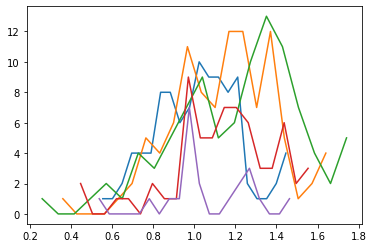

In [95]:
step_list = np.logspace(1.1, 3)
step_list = np.logspace(1.1, 4, 5, dtype=int)

bins=20

for step in step_list :
    t, dat = dfile_constant[step, 0], dfile_constant[step, 1:]
    dat = dat[np.argwhere(dat > 0.)]
    y, x = np.histogram(dat, bins=bins)
    x = 0.5*(x[1:]+x[:-1])
    
    plt.plot(x/np.average(x), y)
    

In [96]:
filename = os.path.join(main_dir, subdir, subsubdir, 'run0001', 'distrib_length.dat')

dfile_gaussian = import_distrib(filename, Ncols=101)

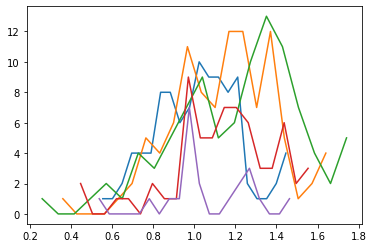

In [97]:
step_list = np.logspace(1.1, 3)
step_list = np.logspace(1.1, 4, 5, dtype=int)

bins=20

for step in step_list :
    t, dat = dfile_gaussian[step, 0], dfile_constant[step, 1:]
    dat = dat[np.argwhere(dat > 0.)]
    y, x = np.histogram(dat, bins=bins)
    x = 0.5*(x[1:]+x[:-1])
    
    plt.plot(x/np.average(x), y)
    